# Interactive Image Understanding
Intro: Image understanding with interactive human instructions

In [1]:
from typing import List
from agentlite.actions import BaseAction
from agentlite.agents import ABCAgent, BaseAgent
from agentlite.llm.agent_llms import BaseLLM, get_llm_backend
from agentlite.logging.multi_agent_log import AgentLogger
from IPython.display import Image, display
from agentlite.llm.LLMConfig import LLMConfig
import requests
from env import openai_api_key
from openai import OpenAI

## Define the Image Agent with its Actions

In [2]:
# Define OpenAI client
Client = OpenAI(api_key = openai_api_key)
URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg"


# Define Image Query Action
class ImageQuery(BaseAction):
    def __init__(self) -> None:
        action_name = "ImageQuery"
        action_desc = "Using this action to obtain the observation from the image given a question."
        params_doc = {"query": "Questions on the image."}
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )


    def __call__(self, query):
        response = Client.chat.completions.create(
            model = "gpt-4-vision-preview",
            messages = [
                {"role": "user",
                 "content": [
                     {"type": "text", "text": query},
                     {
                         "type": "image_url",
                         "image_url": {
                                "url": URL
                            }
                     }
                     
                 ]}
            ],
            max_tokens = 300,
        )

        return response.choices[0].message.content
    

# Define Image Display Action
class ImageDisplay(BaseAction):
    def __init__(self) -> None:
        action_name = "ImageDisplay"
        action_desc = "Using this action to display the image from the url."
        params_doc = {"label": "True"}
        super().__init__(
            action_name=action_name,
            action_desc=action_desc,
            params_doc=params_doc,
        )
    
    # fetch pic from url and display it
    def fetch_and_display(self, url):
        response = requests.get(url)
        
        if response.status_code == 200:
            display(Image(response.content))
        else:
            print("Failed to fetch image from URL: ", url)


    def __call__(self, label):
        self.fetch_and_display(URL)

        return f"The image has been displayed."

## using the agentrool logger to record the running log
agent_logger = AgentLogger(PROMPT_DEBUG_FLAG=False)

# Define the image agent
class ImageAgent(BaseAgent):
    def __init__(
        self,
        llm: BaseLLM,
        actions: List[BaseAction] = [ImageQuery(), ImageDisplay()], 
        manager: ABCAgent = None,
        **kwargs
    ):
        name = "Image_agent"
        role = """You are a image agent, you can use the ImageQuery action to obtain the observation from the image given a question, and use the ImageDisplay action to display the image from the url."""
        super().__init__(
            name=name,
            role=role,
            llm=llm,
            actions=actions,
            manager=manager,
            logger=agent_logger,
        ) 


## Define the Human Agent that directly collects Instructions.

In [3]:
# Define the human agent

class Human(ABCAgent):
    def __init__(self):
        name = "Human"
        role = """You are human to give instructions to all the other agents. You can ask for displaying the image, raise questions based on the image and end the session."""
        super().__init__(
            name=name,
            role=role,
        ) 
    
    def __call__(self, question):
        print(question)
        print("Please input your instruction here: ")
        instruction = input()

        return f"My instruction is: {instruction}"

In [4]:
# Initialize the backend LLM

llm_config_dict = {"llm_name": "gpt-4-32k", "temperature": 0.0, "openai_api_key": openai_api_key}
llm_config = LLMConfig(llm_config_dict)
llm = get_llm_backend(llm_config)

image_agent = ImageAgent(llm=llm)
human_agent = Human()

In [5]:
from agentlite.commons import AgentAct, TaskPackage
from agentlite.actions import ThinkAct, FinishAct
from agentlite.actions.InnerActions import INNER_ACT_KEY
from agentlite.agents.agent_utils import AGENT_CALL_ARG_KEY

# Add an illustration example for the image agent
exp_task = "Display the image."
exp_task_pack = TaskPackage(instruction=exp_task)

act_1 = AgentAct(
    name=ImageDisplay().action_name,
    params={"label": f"""True"""
    },
)
obs_1 = "The image has been displayed."

act_2 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "I have finished the image displaying task."})
obs_2 = "Task Completed. The image has been displayed."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2)]

image_agent.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)

exp_task = "What is in the image?"
exp_task_pack = TaskPackage(instruction=exp_task)

act_1 = AgentAct(
    name=ImageQuery().action_name,
    params={"query": f"""What is there in the image?"""
    },
)
obs_1 = "The image contains a walkway in the middle of grass."

act_2 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "The image contains a walkway in the middle of grass."})
obs_2 = "Task completed. The image contains a walkway in the middle of grass."
exp_act_obs = [(act_1, obs_1), (act_2, obs_2)]

image_agent.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)

## Define the manager agent

In [6]:
# define manager agent
from agentlite.agents import ManagerAgent

manager_agent_info = {
    "name": "manager_agent",
    "role": "You are controlling the image_agent and the human_agent. Each time you need to acquire an instruction from the human_agent, and you should follow the instructions. The human_agent can ask you to control image_agent to display image and answer questions based on the image."
}
team = [image_agent, human_agent]
manager_agent = ManagerAgent(name=manager_agent_info["name"], role=manager_agent_info["role"], llm=llm, TeamAgents=team,logger=agent_logger)


In [7]:
# Add illustration example for the manager agent
exp_task = "Follow instructions from human to ask questions from the image."
exp_task_pack = TaskPackage(instruction=exp_task)


act_1 = AgentAct(
    name=ThinkAct.action_name,
    params={INNER_ACT_KEY: f"""I need to get instruction from human first."""
    },
)
obs_1 = "OK"

act_2 = AgentAct(
    name=human_agent.name,
    params={AGENT_CALL_ARG_KEY: "Do you have any instructions for me?",
        },
)
obs_2 = """I want to have a look on the image."""

act_3 = AgentAct(
    name=image_agent.name,
    params={AGENT_CALL_ARG_KEY: "Display the imgae.",
        },
)
obs_3 = """Task Completed. The image has been displayed."""

act_4 = AgentAct(
    name=ThinkAct.action_name,
    params={INNER_ACT_KEY: f"""I have finished human's instruction, I need to collect the next instruction from human."""
    },
)
obs_4 = "OK"

act_5 = AgentAct(
    name=human_agent.name,
    params={AGENT_CALL_ARG_KEY: "Do you have any instructions for me?",
        },
)
obs_5 = """What is in the image?"""

act_6 = AgentAct(
    name=image_agent.name,
    params={AGENT_CALL_ARG_KEY: "What is in the image?",
        },
)
obs_6 = """The image contains a walkway in the middle of grass."""

act_7 = AgentAct(
    name=ThinkAct.action_name,
    params={INNER_ACT_KEY: f"""I have finished human's instruction, I need to collect the next instruction from human."""
    },
)
obs_7 = "OK"

act_8 = AgentAct(
    name=human_agent.name,
    params={AGENT_CALL_ARG_KEY: "Do you have any instructions for me?",
        },
)
obs_8 = """I have no more instructions for you. We can end the session."""

act_9 = AgentAct(name=FinishAct.action_name, params={INNER_ACT_KEY: "I have no more instructions from human. End the session."})
obs_9 = "Session ended."

exp_act_obs = [(act_1, obs_1), (act_2, obs_2), (act_3, obs_3), (act_4, obs_4), (act_5, obs_5), (act_6, obs_6), (act_7, obs_7), (act_8, obs_8), (act_9, obs_9)]
manager_agent.add_example(
    task = exp_task_pack, action_chain = exp_act_obs
)

## Begin the Task

Agent manager_agent receives the following TaskPackage:
[
	Task ID: 76f59ea4-02f0-442a-a13d-cbfa0d254292
	Instruction: Follow instructions from human to ask questions from the image.
]
====manager_agent starts execution on TaskPackage 76f59ea4-02f0-442a-a13d-cbfa0d254292====


/Users/liangwei.yang/miniconda3/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Agent manager_agent takes 0-step Action:
{
	name: Think
	params: {'response': 'I need to get instruction from human first.'}
}
Observation: OK
Agent manager_agent takes 1-step Action:
{
	name: Human
	params: {'Task': 'Do you have any instructions for me?'}
}
Task ID: 76f59ea4-02f0-442a-a13d-cbfa0d254292
Instruction: Do you have any instructions for me?
Task Creator: 
Task Completion:active
Answer: 
Task Executor: 
Please input your instruction here: 
Observation: My instruction is: I want to see the image.
Agent manager_agent takes 2-step Action:
{
	name: Image_agent
	params: {'Task': 'Display the image.'}
}
Agent Image_agent receives the following TaskPackage:
[
	Task ID: 76f59ea4-02f0-442a-a13d-cbfa0d254292
	Instruction: Display the image.
]
====Image_agent starts execution on TaskPackage 76f59ea4-02f0-442a-a13d-cbfa0d254292====
Agent Image_agent takes 0-step Action:
{
	name: ImageDisplay
	params: {'label': 'True'}
}


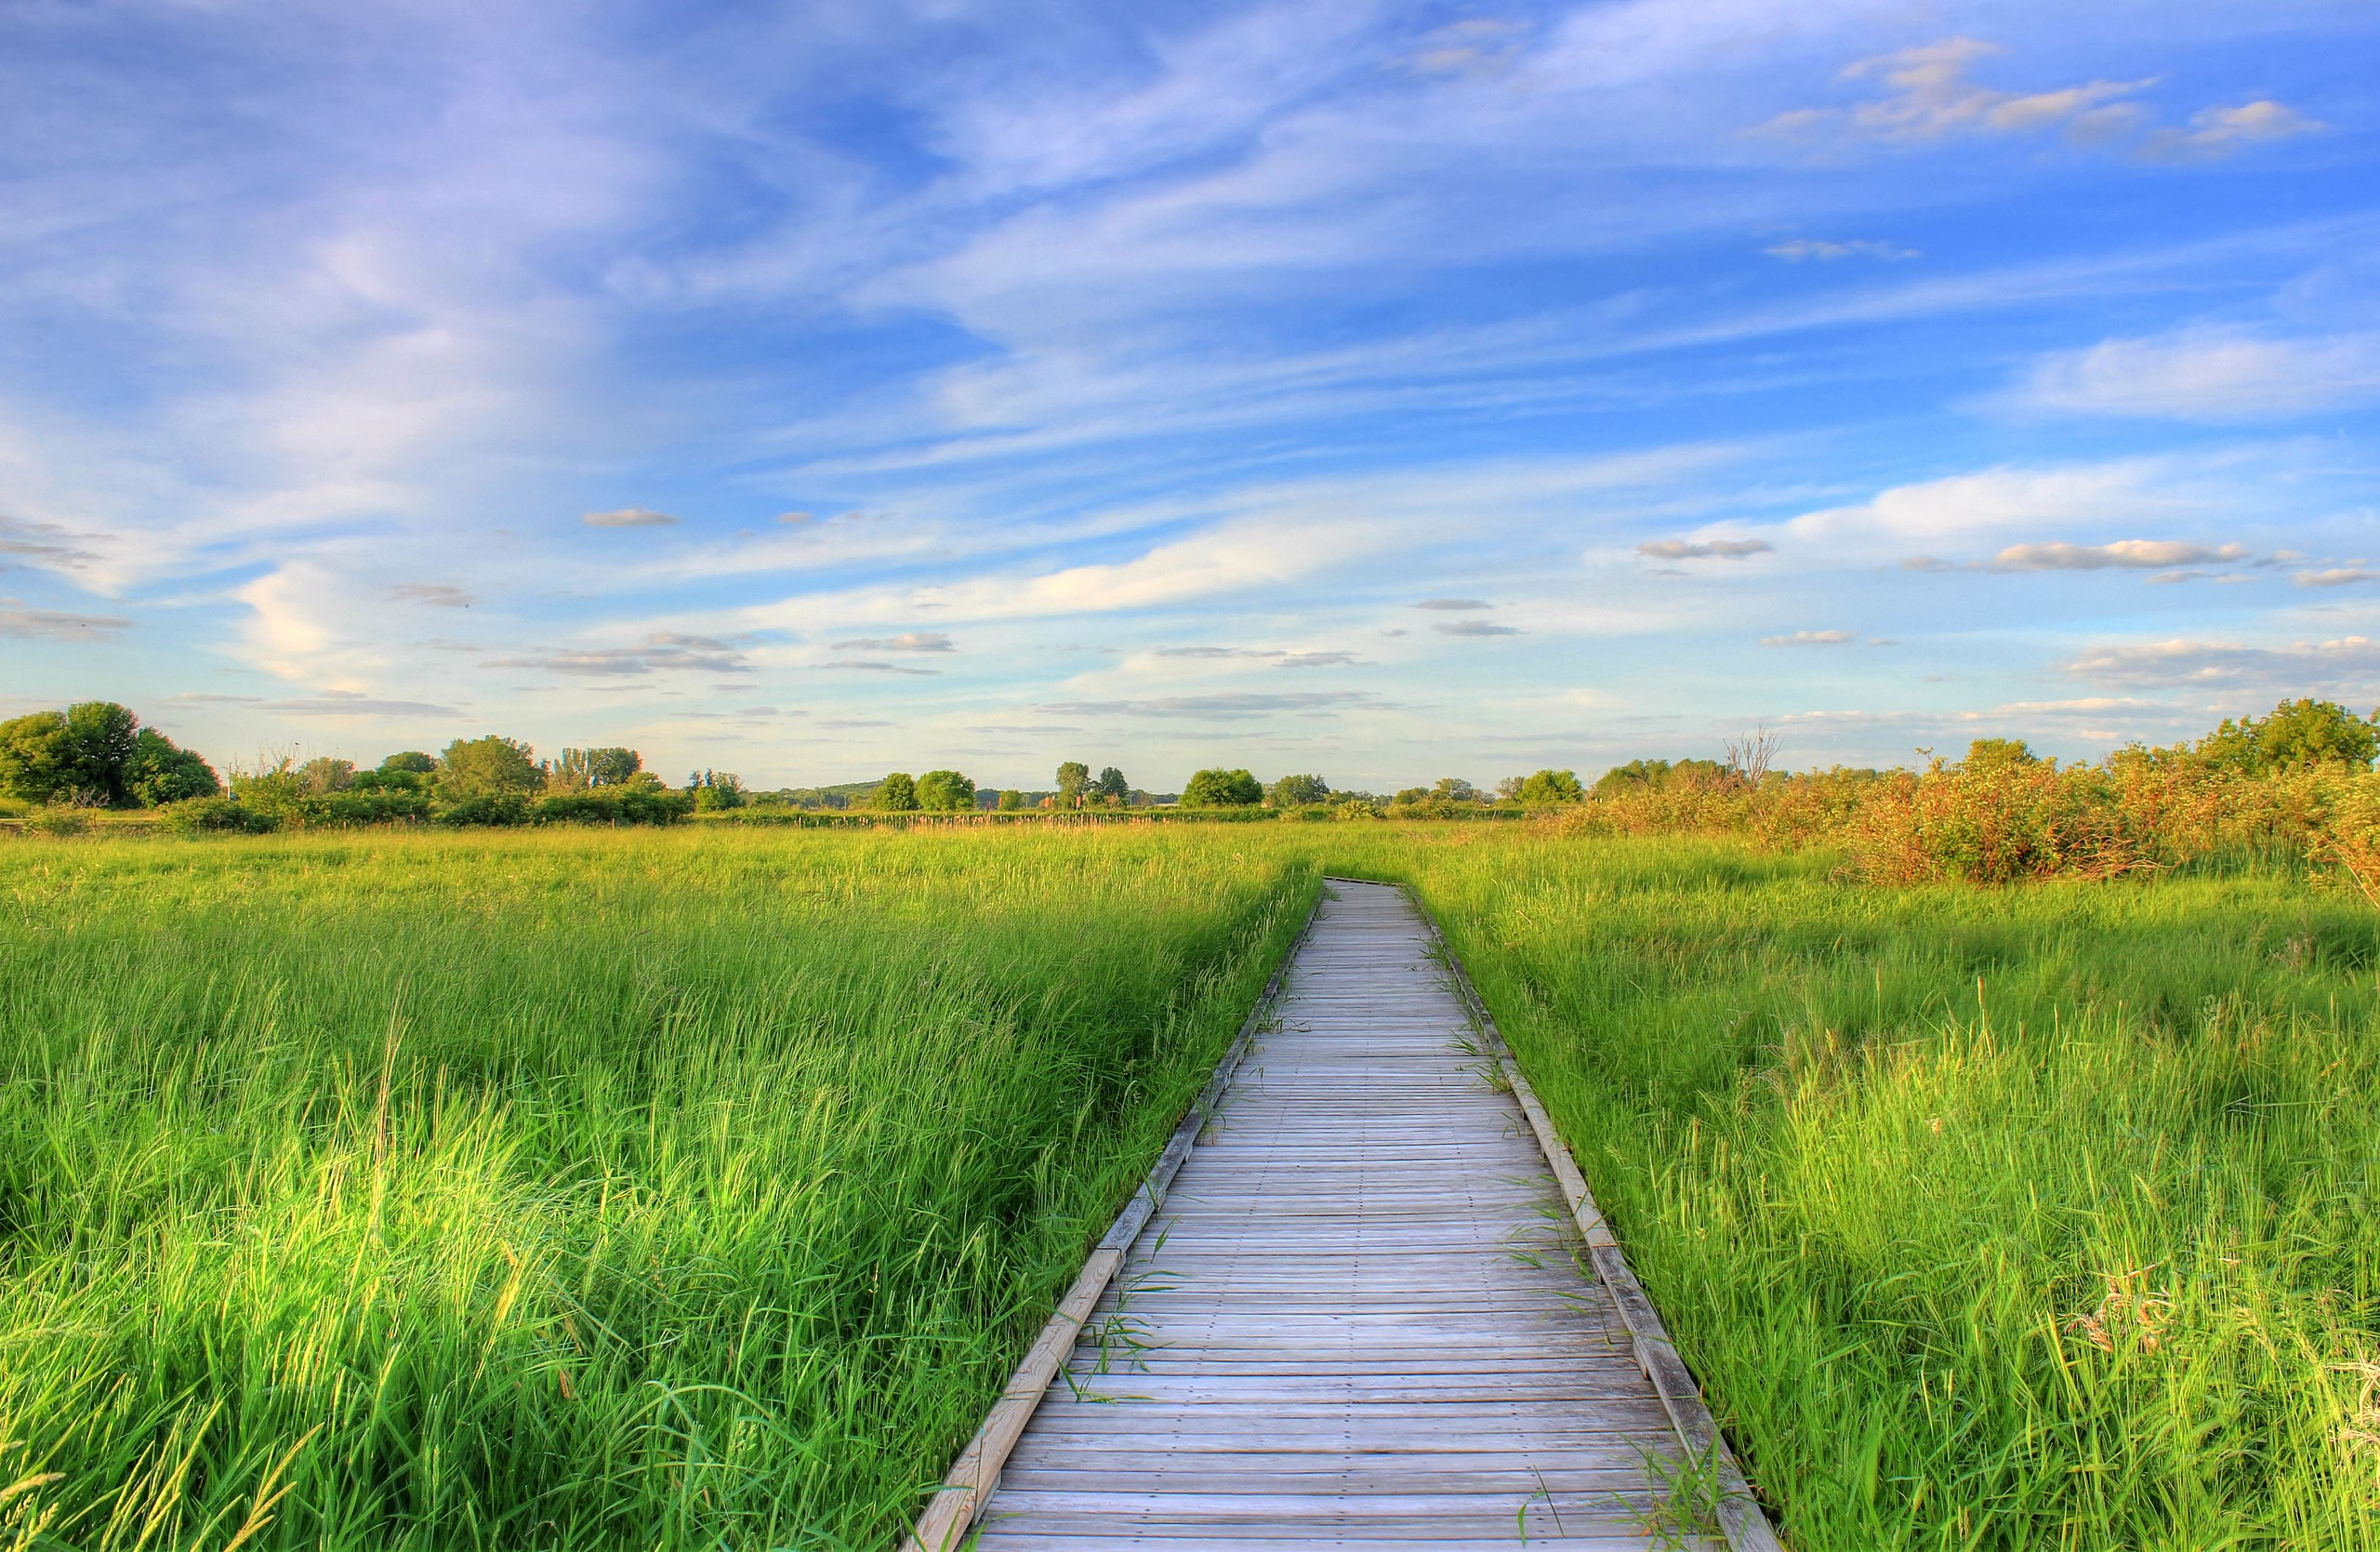

Observation: The image has been displayed.
Agent Image_agent takes 1-step Action:
{
	name: Finish
	params: {'response': 'I have finished the image displaying task.'}
}
Observation: Task Completed.
=========Image_agent finish execution. TaskPackage[ID:76f59ea4-02f0-442a-a13d-cbfa0d254292] status:
[
	completion: completed
	answer: I have finished the image displaying task.
]
Observation: I have finished the image displaying task.
Agent manager_agent takes 3-step Action:
{
	name: Think
	params: {'response': "I have finished human's instruction, I need to collect the next instruction from human."}
}
Observation: OK
Agent manager_agent takes 4-step Action:
{
	name: Human
	params: {'Task': 'Do you have any instructions for me?'}
}
Task ID: 76f59ea4-02f0-442a-a13d-cbfa0d254292
Instruction: Do you have any instructions for me?
Task Creator: 
Task Completion:active
Answer: 
Task Executor: 
Please input your instruction here: 
Observation: My instruction is: What is in the image?
Agent manager_a

'I have no more instructions from human. End the session.'

In [8]:
exp_task = "Follow instructions from human to ask questions from the image."
exp_task_pack = TaskPackage(instruction=exp_task)

manager_agent(exp_task_pack)